Comparing:
 1. search_results_sample.json (Before)
 2. search_results_sample_clean.json (After)
데이터 후처리 전후 결과 비교 (BM25 P@10)
Before (Dirty): 0.2348
After  (Clean): 0.2344
Improvement   : +-0.15%


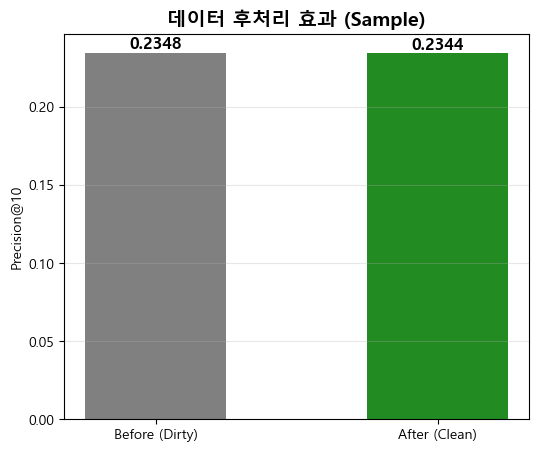

In [4]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

PROJECT_ROOT = Path('..').resolve()
RESULTS_DIR = PROJECT_ROOT / 'results'
DATA_DIR = PROJECT_ROOT / 'data'

FILE_CLEAN = RESULTS_DIR / 'search_results_sample_clean.json'
FILE_DIRTY = RESULTS_DIR / 'search_results_sample.json'

print(f"Comparing:\n 1. {FILE_DIRTY.name} (Before)\n 2. {FILE_CLEAN.name} (After)")

with open(FILE_CLEAN, 'r', encoding='utf-8') as f:
    res_clean = json.load(f)
with open(FILE_DIRTY, 'r', encoding='utf-8') as f:
    res_dirty = json.load(f)

with open(DATA_DIR / 'qrels.pkl', 'rb') as f:
    qrels_list = pickle.load(f)

qrels = defaultdict(set)
for q in qrels_list:
    qrels[q['query-id']].add(q['corpus-id'])

def calculate_p10(search_results):
    scores = []
    for query_res in search_results:
        qid = query_res['query_id']
        if qid not in qrels: continue

        relevant = qrels[qid]
        # BM25 기준 상위 10개
        top10 = [r['doc_id'] for r in query_res['results'][:10]]
        hits = len([d for d in top10 if d in relevant])
        scores.append(hits / 10.0)
    return np.mean(scores)

score_clean = calculate_p10(res_clean)
score_dirty = calculate_p10(res_dirty)

improvement = ((score_clean - score_dirty) / score_dirty) * 100

print("데이터 후처리 전후 결과 비교 (BM25 P@10)")
print(f"Before (Dirty): {score_dirty:.4f}")
print(f"After  (Clean): {score_clean:.4f}")
print(f"Improvement   : +{improvement:.2f}%")

# 시각화
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(['Before (Dirty)', 'After (Clean)'], [score_dirty, score_clean],
              color=['gray', 'forestgreen'], width=0.5)

ax.set_title('데이터 후처리 효과 (Sample)', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision@10')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

데이터 크기, 단어 수 변화

In [2]:
import os
import sqlite3
from pathlib import Path

PROJECT_ROOT = Path('..').resolve()
DB_CLEAN = PROJECT_ROOT / 'database' / 'inverted_index_sample_clean.db'
DB_DIRTY = PROJECT_ROOT / 'database' / 'inverted_index_sample.db'

def get_db_stats(db_path):
    size_mb = os.path.getsize(db_path) / (1024 * 1024)
    conn = sqlite3.connect(str(db_path))
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM inverted_index")
    total_rows = cursor.fetchone()[0]
    cursor.execute("SELECT COUNT(*) FROM term_stats")
    vocab_size = cursor.fetchone()[0]
    conn.close()
    return size_mb, total_rows, vocab_size

clean_stats = get_db_stats(DB_CLEAN)
dirty_stats = get_db_stats(DB_DIRTY)

print(f"{'Metric':<20} | {'Dirty (Before)':<15} | {'Clean (After)':<15} | {'Reduction'}")
print("-" * 65)
print(f"{'File Size (MB)':<20} | {dirty_stats[0]:<15.2f} | {clean_stats[0]:<15.2f} | {-(1 - clean_stats[0]/dirty_stats[0])*100:.1f}%")
print(f"{'Total Index Rows':<20} | {dirty_stats[1]:<15,} | {clean_stats[1]:<15,} | {-(1 - clean_stats[1]/dirty_stats[1])*100:.1f}%")
print(f"{'Vocabulary Size':<20} | {dirty_stats[2]:<15,} | {clean_stats[2]:<15,} | {-(1 - clean_stats[2]/dirty_stats[2])*100:.1f}%")

Metric               | Dirty (Before)  | Clean (After)   | Reduction
-----------------------------------------------------------------
File Size (MB)       | 465.95          | 455.16          | -2.3%
Total Index Rows     | 2,904,653       | 2,848,120       | -1.9%
Vocabulary Size      | 153,410         | 153,179         | -0.2%
